MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [3]:
import pandas as pd

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -8 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [6]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [8]:
# Create Wellbeing column
df['Wellbeing'] = df[['SATIS', 'WORTH', 'HAPPY']].mean(axis=1, skipna=True)

# Check the result
df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head()

,SATIS,WORTH,HAPPY,Wellbeing
0,8.0,8.0,7.0,7.666667
1,10.0,8.0,10.0,9.333333
2,10.0,9.0,10.0,9.666667
3,-9.0,-9.0,-9.0,-9.000000
4,8.0,5.0,8.0,7.000000


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [10]:
# Replace missing codes in Wellbeing column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 4:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Very high'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)

# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,High,7.0,High
1,9.333333,Very high,0.0,Very low
2,9.666667,Very high,0.0,Very low
3,<NA>,<NA>,<NA>,<NA>
4,7.0,High,1.0,Very low


In [11]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing             169132
Wellbeing_category    169132
ANXIOUS               169369
Anxiety_category      169369
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [13]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In [14]:
category_order = {
    'Low': 0,
    'Medium': 1,
    'High': 2,
    'Very high': 3
}
cleaned = cleaned.copy()
cleaned['Wellbeing_category_num'] = cleaned['Wellbeing_category'].map(category_order)

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [16]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [17]:
import numpy as np

# Define mapping
aage_to_avg = {
    2.0: 17,  # 16-17
    3.0: 19,  # 18-19
    4.0: 22,    # 20-24
    5.0: 27,    # 25-29
    6.0: 32,    # 30-34
    7.0: 37,    # 35-39
    8.0: 42,    # 40-44
    9.0: 47,    # 45-49
    10.0: 52,   # 50-54
    11.0: 57,   # 55-59
    12.0: 62,   # 60-64
    13.0: 82    # 65-99
}

# Apply mapping 
cleaned['AGE'] = cleaned['AAGE'].map(aage_to_avg)

# Map GOR9d to numeric codes
region_map = {
    'E12000001': 1,  # North East
    'E12000002': 2,  # North West
    'E12000003': 3,  # Yorkshire and The Humber
    'E12000004': 4,  # East Midlands
    'E12000005': 5,  # West Midlands
    'E12000006': 6,  # East of England
    'E12000007': 7,  # London
    'E12000008': 8,  # South East
    'E12000009': 9,  # South West
    'L99999999': 10, # Channel Islands (pseudo)
    'M99999999': 11, # Isle of Man (pseudo)
    'N99999999': 12, # Northern Ireland
    'S99999999': 13, # Scotland (pseudo)
    'W99999999': 14  # Wales (pseudo)
}

# Apply the mapping to create a new column
cleaned['GOR9d_num'] = cleaned['GOR9d'].map(region_map)

# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype
for col in health_cols:
    cleaned[col] = cleaned[col].astype('Int64')

# Step 3: Replace -8 with NaN (keep -9)
cleaned[health_cols] = cleaned[health_cols].replace(-8, np.nan)

# Step 4: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 5: Only create columns if they don’t already exist
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'
    if col_name not in cleaned.columns:
        cleaned[col_name] = cleaned[health_cols].apply(
            lambda row: int(code in row.dropna().values), axis=1
        )

print("HEALTH columns created.")

HEALTH columns created.


In [18]:
cleaned.to_csv("cleaned.csv", index=False)

In [3]:
import pandas as pd
cleaned = pd.read_csv("cleaned.csv",low_memory=False)

## **Data exploration**


In [11]:
# Dictionary
feature_labels = {
    # SEX
    'SEX_1': 'Male',
    'SEX_2': 'Female',

    # ETHUKEUL (Ethnicity)
    'ETHUKEUL_1.0': 'White',
    'ETHUKEUL_2.0': 'Mixed/Multiple ethnic groups',
    'ETHUKEUL_3.0': 'Indian',
    'ETHUKEUL_4.0': 'Pakistani',
    'ETHUKEUL_5.0': 'Bangladeshi',
    'ETHUKEUL_6.0': 'Chinese',
    'ETHUKEUL_7.0': 'Any other Asian background',
    'ETHUKEUL_8.0': 'Black/African/Caribbean/Black British',
    'ETHUKEUL_9.0': 'Other ethnic group',

    # MARDY6 (Marital status)
    'MARDY6_1': 'Married/Cohabiting/Civil Partner',
    'MARDY6_2': 'Non-married',

    # ILODEFR (Economic activity)
    'ILODEFR_1': 'In employment',
    'ILODEFR_2': 'ILO unemployed',
    'ILODEFR_3': 'Inactive',

    # TEN1 (Accommodation details)
    'TEN1_1.0': 'Owned outright',
    'TEN1_2.0': 'Being bought with mortgage or loan',
    'TEN1_3.0': 'Part rent, part mortgage',
    'TEN1_4.0': 'Rented',
    'TEN1_5.0': 'Rent free or squatted',
    'TEN1_6.0': 'Squatting',

    # XDISDDA20 (Unadjusted DDA disabled)
    'XDISDDA20_-9': 'Does not apply',
    'XDISDDA20_1': 'Current disability only',
    'XDISDDA20_2': 'Current and past disabled',
    'XDISDDA20_3': 'Past disability only',
    'XDISDDA20_4': 'Not DDA disabled',

    # LEVQUL22 (RQF Level of highest qualification)
    'LEVQUL22_-9': 'Does not apply',
    'LEVQUL22_1': 'RQF Level 8 (Doctorate)',
    'LEVQUL22_2': 'RQF Level 7 (Master’s)',
    'LEVQUL22_3': 'RQF Level 6 (Bachelor’s)',
    'LEVQUL22_4': 'RQF Level 5 (HND/Foundation Degree)',
    'LEVQUL22_5': 'RQF Level 4 (CertHE)',
    'LEVQUL22_6': 'RQF Level 3 (A-Levels)',
    'LEVQUL22_7': 'RQF Level 2 (GCSE A*-C)',
    'LEVQUL22_8': 'RQF Level 1 (GCSE D-G)',
    'LEVQUL22_9': 'RQF Entry Level',
    'LEVQUL22_10': 'Other Qualifications',
    'LEVQUL22_11': 'No Qualifications',
    'LEVQUL22_12': 'Don’t Know (Qualification)',

    # INDE07M (Industry sector in main job)
    'INDE07M_-9.0': 'Does not apply',
    'INDE07M_1.0': 'Agriculture, forestry and fishing',
    'INDE07M_2.0': 'Energy and water',
    'INDE07M_3.0': 'Manufacturing',
    'INDE07M_4.0': 'Construction',
    'INDE07M_5.0': 'Distribution, hotels and restaurants',
    'INDE07M_6.0': 'Transport and communication',
    'INDE07M_7.0': 'Banking and finance',
    'INDE07M_8.0': 'Public admin, education and health',
    'INDE07M_9.0': 'Other services',

    # RELIG11 (Religion)
    'RELIG11_1.0': 'No Religion',
    'RELIG11_2.0': 'Christian',
    'RELIG11_3.0': 'Buddhist',
    'RELIG11_4.0': 'Hindu',
    'RELIG11_5.0': 'Jewish',
    'RELIG11_6.0': 'Muslim',
    'RELIG11_7.0': 'Sikh',
    'RELIG11_8.0': 'Other Religion',

    # GOR9d (Region)
    'GOR9d_num_1': 'North East',
    'GOR9d_num_2': 'North West',
    'GOR9d_num_3': 'Yorkshire and The Humber',
    'GOR9d_num_4': 'East Midlands',
    'GOR9d_num_5': 'West Midlands',
    'GOR9d_num_6': 'East of England',
    'GOR9d_num_7': 'London',
    'GOR9d_num_8': 'South East',
    'GOR9d_num_9': 'South West',
    'GOR9d_num_10': '(pseudo) Channel Islands',
    'GOR9d_num_11': '(pseudo) Isle of Man',
    'GOR9d_num_12': 'Northern Ireland',
    'GOR9d_num_13': '(pseudo) Scotland',
    'GOR9d_num_14': '(pseudo) Wales',

    # HEALTH binary indicators
    'HEALTH_Diabetes': 'Diabetes',
    'HEALTH_MentalAnxiety': 'Mental Anxiety',
    'HEALTH_ArmsOrHands': 'Arms/Hands Disability',
    'HEALTH_LegsOrFeet': 'Legs/Feet Disability',
    'HEALTH_BackOrNeck': 'Back/Neck Disability',
    'HEALTH_MentalIllness': 'Mentai Illness',
    'HEALTH_Autism': 'Autism',
    'HEALTH_ProgressiveIllness': 'ProgressiveIllness',
    'HEALTH_HeartOrCirculation': 'HeartOrCirculation',
    'NATIDB11': 'British Identity',
}

In [13]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE

# --- Feature Groups ---
columns = {
    'AGE': 'AGE',
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'XDISDDA20',
    'QUALIFICATION': 'LEVQUL22',
    'Job_Sector': 'INDE07M',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d_num',
    'DIABETES': 'HEALTH_Diabetes',
    'MentalAnxiety': 'HEALTH_MentalAnxiety',
    'ArmsDisability': 'HEALTH_ArmsOrHands',
    'LegsDisability': 'HEALTH_LegsOrFeet',
    'BackDisability': 'HEALTH_BackOrNeck',
    'MentalIllness': 'HEALTH_MentalIllness',
    'Autism': 'HEALTH_Autism',
    'ProgressiveIllness': 'HEALTH_ProgressiveIllness',
    'HeartOrCirculation': 'HEALTH_HeartOrCirculation'
}

nominal_cols = [
    'LEVQUL22', 'ILODEFR', 'MARDY6', 'SEX',
    'ETHUKEUL', 'TEN1', 'XDISDDA20', 'INDE07M', 'RELIG11', 'GOR9d_num'
]

binary_cols = [
    'NATIDB11', 'HEALTH_Diabetes', 'HEALTH_MentalAnxiety',
    'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 
    'HEALTH_BackOrNeck','HEALTH_MentalIllness', 'HEALTH_Autism',
    'HEALTH_ProgressiveIllness', 'HEALTH_HeartOrCirculation'
]

continuous_cols = ['AGE']

print("Imports and column groups loaded.")

Imports and column groups loaded.


In [14]:
# --- Step 1: Clean and prepare base dataframe ---
relevant_cols = list(columns.values()) + ['Wellbeing_category_num']
model_df = cleaned[relevant_cols].copy().dropna()

X = model_df[list(columns.values())].copy()
y = model_df['Wellbeing_category_num'].copy()

X[binary_cols] = X[binary_cols].astype(int)
X[nominal_cols] = X[nominal_cols].astype('category')
X[continuous_cols] = X[continuous_cols].apply(pd.to_numeric, errors='coerce')

# --- Step 2: One-hot encode nominal columns ---
X_nominal = pd.get_dummies(X[nominal_cols], drop_first=False)
X_final = pd.concat([X[continuous_cols], X[binary_cols], X_nominal], axis=1)

# --- Step 3: Split into train/val/test ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Data prepared and split.")
print(f"Train:       {X_train.shape}")
print(f"Validation:  {X_val.shape}")
print(f"Test:        {X_test.shape}")

Data prepared and split.
Train:       (113869, 78)
Validation:  (24401, 78)
Test:        (24401, 78)


In [15]:
# --- Step 1: Scale continuous features ---
scaler = StandardScaler()
X_train_scaled_cont = scaler.fit_transform(X_train[continuous_cols])
X_val_scaled_cont = scaler.transform(X_val[continuous_cols])
X_test_scaled_cont = scaler.transform(X_test[continuous_cols])

# --- Step 2: Combine final feature sets ---
X_train_scaled = np.hstack([
    X_train_scaled_cont,
    X_train[binary_cols].values,
    X_train[X_nominal.columns].values
])
X_val_scaled = np.hstack([
    X_val_scaled_cont,
    X_val[binary_cols].values,
    X_val[X_nominal.columns].values
])
X_test_scaled = np.hstack([
    X_test_scaled_cont,
    X_test[binary_cols].values,
    X_test[X_nominal.columns].values
])

# --- Step 3: Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Step 4: Output shape summary ---
print(f"One-Hot Encoded Train:       {X_train_scaled.shape}")
print(f"One-Hot Encoded Validation:  {X_val_scaled.shape}")
print(f"One-Hot Encoded Test:        {X_test_scaled.shape}")
print(f"One-Hot Encoded Train (SMOTE): {X_train_resampled.shape}")

One-Hot Encoded Train:       (113869, 78)
One-Hot Encoded Validation:  (24401, 78)
One-Hot Encoded Test:        (24401, 78)
One-Hot Encoded Train (SMOTE): (207348, 78)


Train shape (original): (113869, 21)
Validation:             (24401, 21)
Test:                   (24401, 21)
Train shape (SMOTE):    (207348, 21)

Wellbeing_category_num distribution in y_train (BEFORE SMOTE):
Wellbeing_category_num
0.0     4042
1.0    13114
2.0    51837
3.0    44876
Name: count, dtype: int64

Wellbeing_category_num distribution in y_train (AFTER SMOTE):
Wellbeing_category_num
0.0    51837
1.0    51837
2.0    51837
3.0    51837
Name: count, dtype: int64


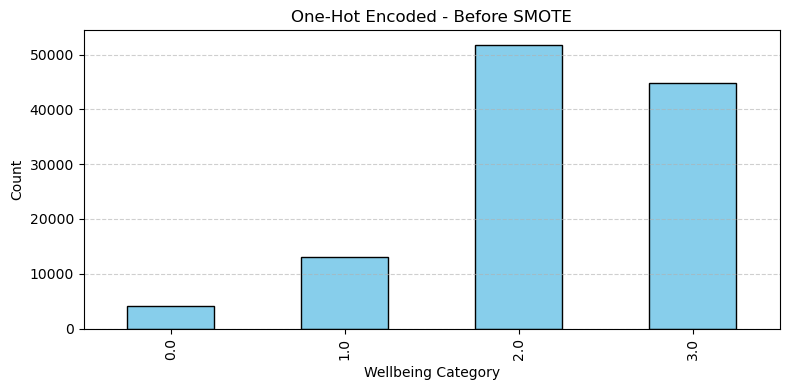

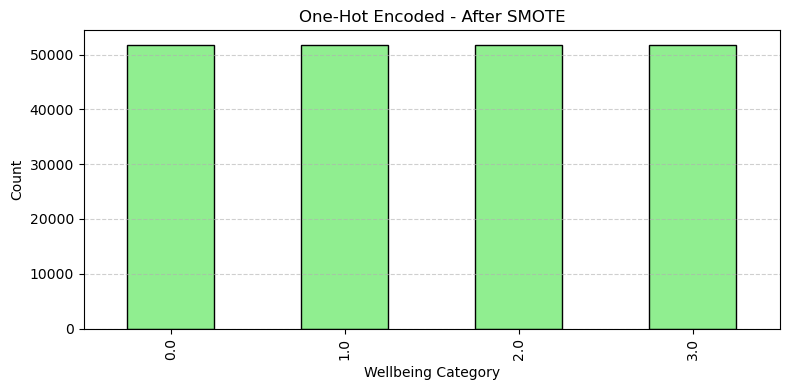

In [17]:
# --- Step 1: Copy and label-encode nominal columns ---
X_label = X.copy()
ordinal_encoder = OrdinalEncoder()
X_label[nominal_cols] = ordinal_encoder.fit_transform(X_label[nominal_cols])

# --- Step 2: Reuse train/val/test indices ---
X_train_idx = X_train.index
X_val_idx = X_val.index
X_test_idx = X_test.index

# --- Step 3: Scale continuous for label-encoded version ---
scaler_label = StandardScaler()
X_train_label_scaled_cont = scaler_label.fit_transform(X_label.loc[X_train_idx, continuous_cols])
X_val_label_scaled_cont = scaler_label.transform(X_label.loc[X_val_idx, continuous_cols])
X_test_label_scaled_cont = scaler_label.transform(X_label.loc[X_test_idx, continuous_cols])

# --- Step 4: Combine label-encoded features ---
X_train_label_final = np.hstack([
    X_train_label_scaled_cont,
    X_label.loc[X_train_idx, binary_cols].values,
    X_label.loc[X_train_idx, nominal_cols].values
])
X_val_label_final = np.hstack([
    X_val_label_scaled_cont,
    X_label.loc[X_val_idx, binary_cols].values,
    X_label.loc[X_val_idx, nominal_cols].values
])
X_test_label_final = np.hstack([
    X_test_label_scaled_cont,
    X_label.loc[X_test_idx, binary_cols].values,
    X_label.loc[X_test_idx, nominal_cols].values
])

# --- Step 5: Apply SMOTE to label-encoded set ---
smote_label = SMOTE(random_state=42)
X_train_label_resampled, y_train_label_resampled = smote_label.fit_resample(X_train_label_final, y_train)

# --- Step 6: Output shape summary ---
print(f"Train shape (original): {X_train_label_final.shape}")
print(f"Validation:             {X_val_label_final.shape}")
print(f"Test:                   {X_test_label_final.shape}")
print(f"Train shape (SMOTE):    {X_train_label_resampled.shape}")

# --- Step 7: Output distribution before & after SMOTE ---
print("\nWellbeing_category_num distribution in y_train (BEFORE SMOTE):")
print(y_train.value_counts(dropna=False).sort_index())

print("\nWellbeing_category_num distribution in y_train (AFTER SMOTE):")
print(pd.Series(y_train_resampled).value_counts().sort_index())

# --- Step 8: Visualize ---
plt.figure(figsize=(8, 4))
y_train.value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("One-Hot Encoded - Before SMOTE")
plt.xlabel("Wellbeing Category")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
pd.Series(y_train_resampled).value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("One-Hot Encoded - After SMOTE")
plt.xlabel("Wellbeing Category")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

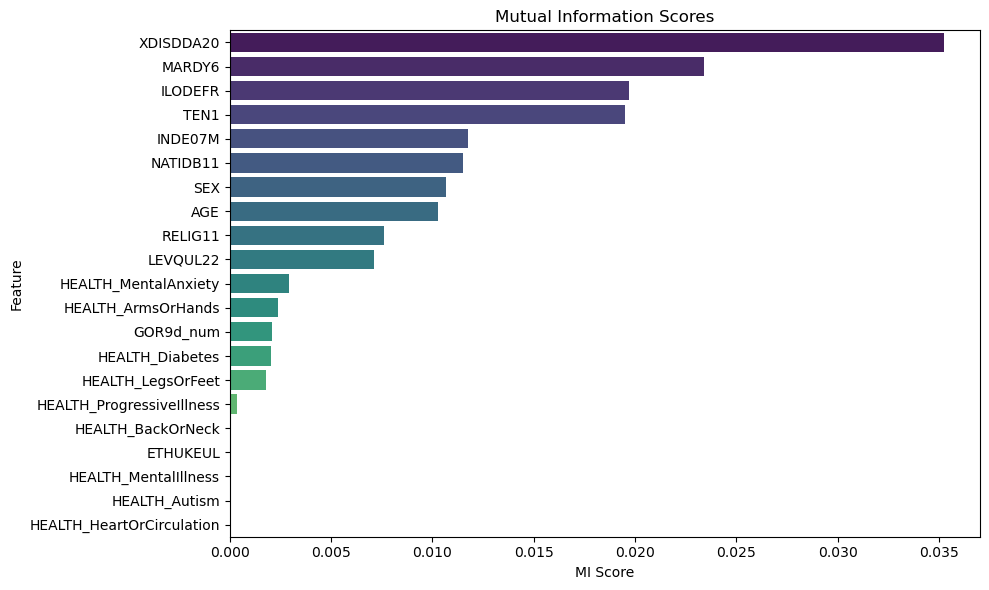

In [18]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
# --- Mutual Information Feature Importance ---
mi_scores = mutual_info_classif(X_label, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=mi_df,
    x='MI Score',
    y='Feature',
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## **Model building**


Model: Random Forest
Train Accuracy: 0.8433
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93     51837
         1.0       0.87      0.84      0.86     51837
         2.0       0.87      0.74      0.80     51837
         3.0       0.73      0.86      0.79     51837

    accuracy                           0.84    207348
   macro avg       0.85      0.84      0.84    207348
weighted avg       0.85      0.84      0.84    207348



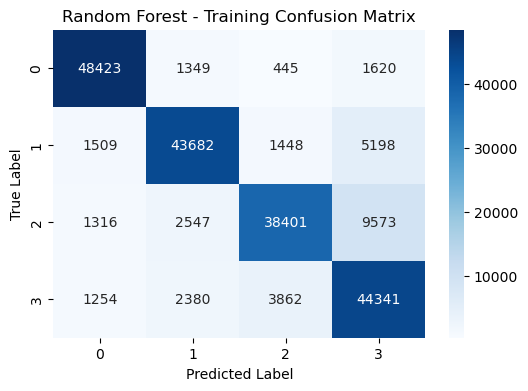

Test Accuracy: 0.4287
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.10      0.11      0.10       866
         1.0       0.18      0.16      0.17      2811
         2.0       0.49      0.46      0.48     11108
         3.0       0.46      0.49      0.48      9616

    accuracy                           0.43     24401
   macro avg       0.31      0.31      0.31     24401
weighted avg       0.43      0.43      0.43     24401



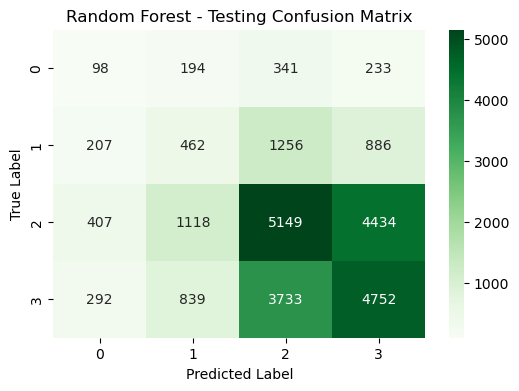


Model: XGBoost
Train Accuracy: 0.5951
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76     51837
         1.0       0.67      0.46      0.55     51837
         2.0       0.52      0.57      0.55     51837
         3.0       0.49      0.55      0.52     51837

    accuracy                           0.60    207348
   macro avg       0.60      0.60      0.59    207348
weighted avg       0.60      0.60      0.59    207348



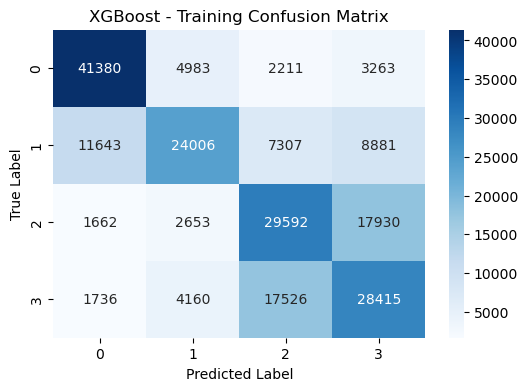

Test Accuracy: 0.4695
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.16      0.19      0.18       866
         1.0       0.21      0.11      0.15      2811
         2.0       0.51      0.54      0.52     11108
         3.0       0.50      0.52      0.51      9616

    accuracy                           0.47     24401
   macro avg       0.34      0.34      0.34     24401
weighted avg       0.46      0.47      0.46     24401



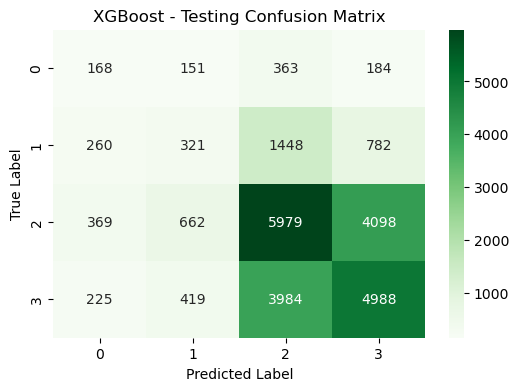


Model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5116
[LightGBM] [Info] Number of data points in the train set: 207348, number of used features: 21
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Train Accuracy: 0.5678
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.79      0.73     51837
         1.0       0.63      0.39      0.48     51837
         2.0       0.51      0.57      0.54     51837
         3.0       0.47      0.52      0.49     51837

    accuracy                           0.57    207348
   macro avg       0.57      0.5

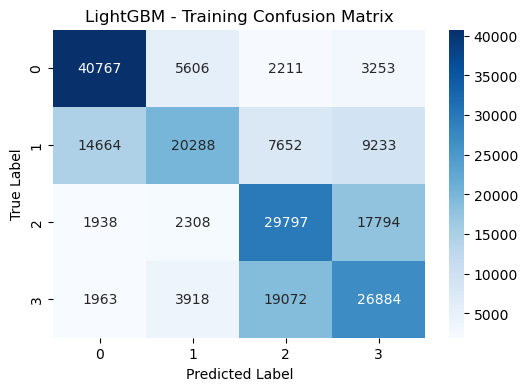

Test Accuracy: 0.4717
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.16      0.21      0.18       866
         1.0       0.20      0.09      0.12      2811
         2.0       0.51      0.56      0.53     11108
         3.0       0.50      0.51      0.50      9616

    accuracy                           0.47     24401
   macro avg       0.34      0.34      0.33     24401
weighted avg       0.46      0.47      0.46     24401



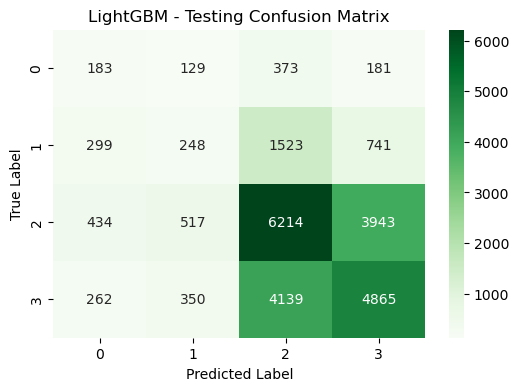

In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- Initialize models ---
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

# --- Train, predict, and evaluate ---
for name, model in models.items():
    print(f"\nModel: {name}")
    
    # Train
    model.fit(X_train_label_resampled, y_train_label_resampled)

    # Predict on training set
    y_pred_train = model.predict(X_train_label_resampled)
    acc_train = accuracy_score(y_train_label_resampled, y_pred_train)
    print(f"Train Accuracy: {acc_train:.4f}")
    print("Training Classification Report:")
    print(classification_report(y_train_label_resampled, y_pred_train))
    
    cm_train = confusion_matrix(y_train_label_resampled, y_pred_train)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Training Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Predict on test set
    y_pred_test = model.predict(X_test_label_final)
    acc_test = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy: {acc_test:.4f}")
    print("Testing Classification Report:")
    print(classification_report(y_test, y_pred_test))
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} - Testing Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Top 10 features:
 Train - Accuracy: 0.5444, F1: 0.5691, AUC: 0.7692
 Test  - Accuracy: 0.4703, F1: 0.2554, AUC: 0.5193

Top 11 features:
 Train - Accuracy: 0.5473, F1: 0.5720, AUC: 0.7718
 Test  - Accuracy: 0.4703, F1: 0.2563, AUC: 0.5199

Top 12 features:
 Train - Accuracy: 0.5724, F1: 0.5948, AUC: 0.8074
 Test  - Accuracy: 0.4634, F1: 0.2737, AUC: 0.5409

Top 13 features:
 Train - Accuracy: 0.5815, F1: 0.6018, AUC: 0.8230
 Test  - Accuracy: 0.4551, F1: 0.2923, AUC: 0.5629

Top 14 features:
 Train - Accuracy: 0.6214, F1: 0.6224, AUC: 0.8523
 Test  - Accuracy: 0.4281, F1: 0.3087, AUC: 0.5968

Top 15 features:
 Train - Accuracy: 0.6403, F1: 0.6411, AUC: 0.8660
 Test  - Accuracy: 0.4308, F1: 0.3100, AUC: 0.5926

Top 16 features:
 Train - Accuracy: 0.6523, F1: 0.6529, AUC: 0.8758
 Test  - Accuracy: 0.4279, F1: 0.3088, AUC: 0.5888

Top 17 features:
 Train - Accuracy: 0.6739, F1: 0.6744, AUC: 0.8921
 Test  - Accuracy: 0.4232, F1: 0.3100, AUC: 0.5833

Top 18 features:
 Train - Accuracy: 0.69

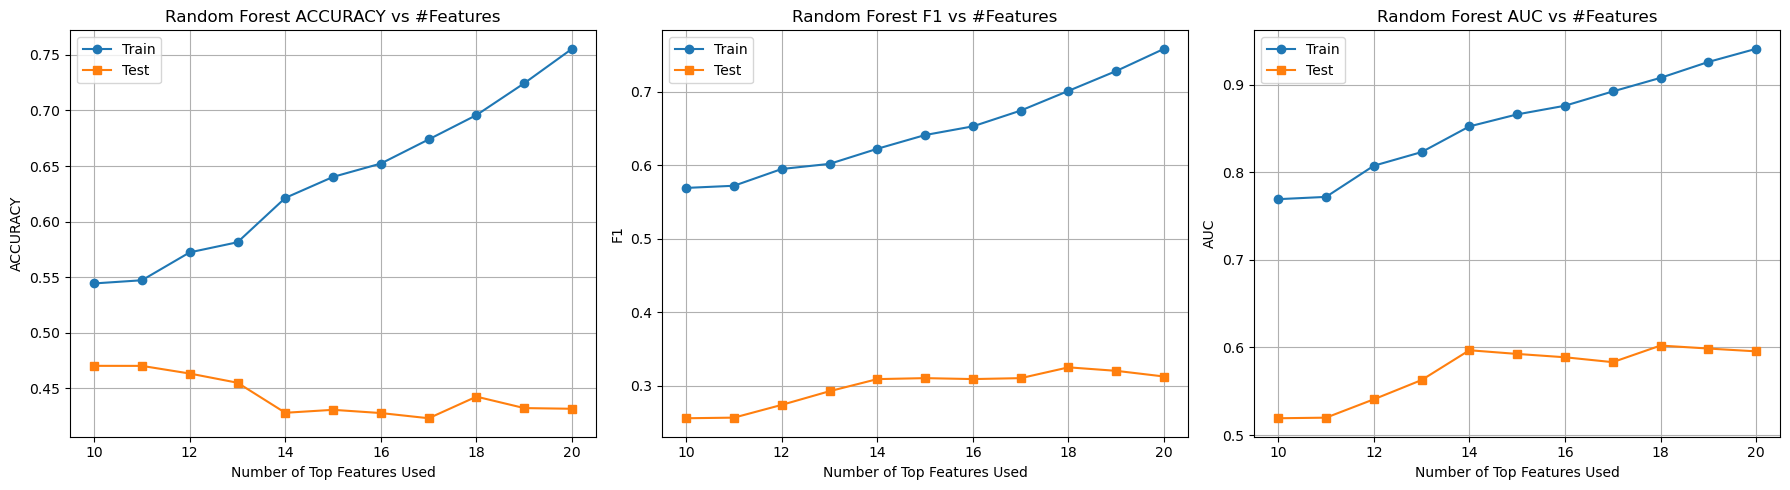

In [36]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

rf = RandomForestClassifier(random_state=42)

mi_ordered_features = mi_df['Feature'].tolist()

start_features = 10
end_features = 20

# Store metrics
train_metrics = {'accuracy': [], 'f1': [], 'auc': []}
test_metrics = {'accuracy': [], 'f1': [], 'auc': []}

# Binarize labels for multiclass AUC calculation
classes = sorted(np.unique(y_train_label_resampled))
y_train_bin = label_binarize(y_train_label_resampled, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

for n_features in range(start_features, end_features + 1):
    selected_features = mi_ordered_features[:n_features]
    selected_indices = [mi_ordered_features.index(feat) for feat in selected_features]

    X_train_sub = X_train_label_resampled[:, selected_indices]
    X_test_sub = X_test_label_final[:, selected_indices]

    rf.fit(X_train_sub, y_train_label_resampled)

    # Predict labels
    y_pred_train = rf.predict(X_train_sub)
    y_pred_test = rf.predict(X_test_sub)

    # Predict probabilities for AUC
    y_prob_train = rf.predict_proba(X_train_sub)
    y_prob_test = rf.predict_proba(X_test_sub)

    # Train metrics
    acc_train = accuracy_score(y_train_label_resampled, y_pred_train)
    f1_train = f1_score(y_train_label_resampled, y_pred_train, average='macro')
    auc_train = roc_auc_score(y_train_bin, y_prob_train, average='macro', multi_class='ovr')

    # Test metrics
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    auc_test = roc_auc_score(y_test_bin, y_prob_test, average='macro', multi_class='ovr')

    # Append metrics
    train_metrics['accuracy'].append(acc_train)
    train_metrics['f1'].append(f1_train)
    train_metrics['auc'].append(auc_train)

    test_metrics['accuracy'].append(acc_test)
    test_metrics['f1'].append(f1_test)
    test_metrics['auc'].append(auc_test)

    print(f"Top {n_features} features:")
    print(f" Train - Accuracy: {acc_train:.4f}, F1: {f1_train:.4f}, AUC: {auc_train:.4f}")
    print(f" Test  - Accuracy: {acc_test:.4f}, F1: {f1_test:.4f}, AUC: {auc_test:.4f}\n")

# Plot all metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
metrics_names = ['accuracy', 'f1', 'auc']
for i, metric in enumerate(metrics_names):
    axs[i].plot(range(start_features, end_features + 1), train_metrics[metric], marker='o', label='Train')
    axs[i].plot(range(start_features, end_features + 1), test_metrics[metric], marker='s', label='Test')
    axs[i].set_title(f'Random Forest {metric.upper()} vs #Features')
    axs[i].set_xlabel('Number of Top Features Used')
    axs[i].set_ylabel(metric.upper())
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


Model: Logistic Regression
Training Performance:
              precision    recall  f1-score   support

         0.0       0.46      0.60      0.52     51837
         1.0       0.33      0.18      0.24     51837
         2.0       0.37      0.31      0.34     51837
         3.0       0.40      0.52      0.45     51837

    accuracy                           0.40    207348
   macro avg       0.39      0.40      0.39    207348
weighted avg       0.39      0.40      0.39    207348



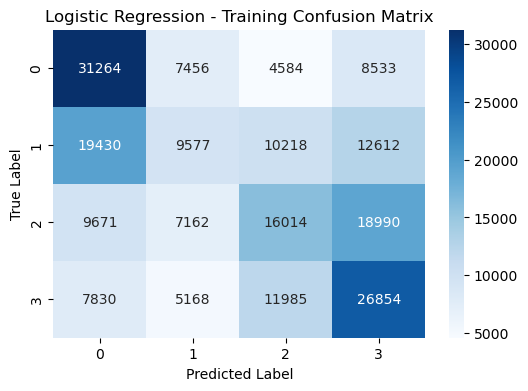

Testing Performance:
              precision    recall  f1-score   support

         0.0       0.10      0.59      0.17       866
         1.0       0.16      0.17      0.16      2811
         2.0       0.54      0.30      0.39     11108
         3.0       0.50      0.52      0.51      9616

    accuracy                           0.38     24401
   macro avg       0.32      0.39      0.31     24401
weighted avg       0.46      0.38      0.40     24401



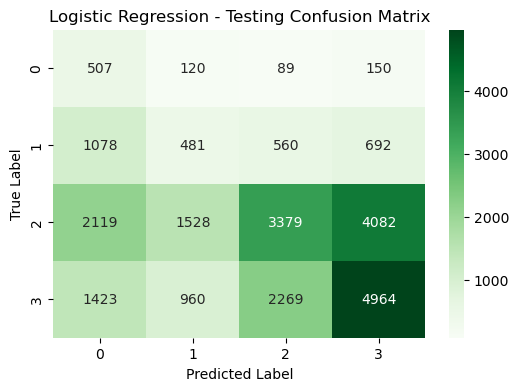


Model: K-Nearest Neighbors
Training Performance:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85     51837
         1.0       0.68      0.76      0.72     51837
         2.0       0.52      0.52      0.52     51837
         3.0       0.61      0.52      0.56     51837

    accuracy                           0.67    207348
   macro avg       0.66      0.67      0.66    207348
weighted avg       0.66      0.67      0.66    207348



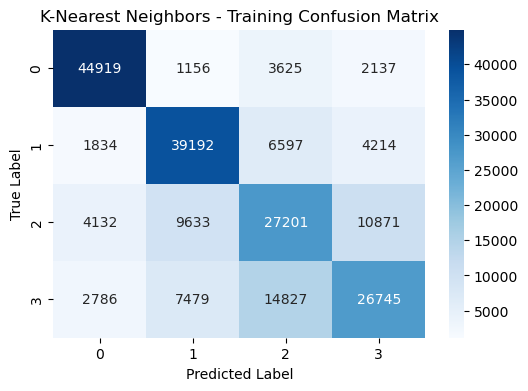

Testing Performance:
              precision    recall  f1-score   support

         0.0       0.08      0.21      0.11       866
         1.0       0.14      0.29      0.19      2811
         2.0       0.47      0.38      0.42     11108
         3.0       0.46      0.34      0.39      9616

    accuracy                           0.35     24401
   macro avg       0.29      0.31      0.28     24401
weighted avg       0.41      0.35      0.37     24401



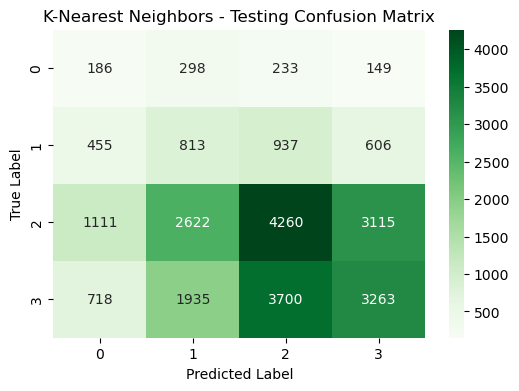

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# List of models to test
models_onehot = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    #"SVM (Linear Kernel)": SVC(kernel='linear', random_state=42),
    #"SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42),
    #"Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

for name, model in models_onehot.items():
    print(f"\nModel: {name}")
    
    # Train
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on training set
    y_pred_train = model.predict(X_train_resampled)
    print("Training Performance:")
    print(classification_report(y_train_resampled, y_pred_train))

    # Confusion matrix for training set
    cm_train = confusion_matrix(y_train_resampled, y_pred_train)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Training Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Predict on test set
    y_pred_test = model.predict(X_test_scaled)
    print("Testing Performance:")
    print(classification_report(y_test, y_pred_test))

    # Confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} - Testing Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()